In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import json
from tqdm import tqdm
from scipy.stats import weibull_min
import autograd.numpy as np
import pandas as pd
plt.style.use('seaborn')
%matplotlib inline

from lifelines import WeibullFitter, KaplanMeierFitter, ExponentialFitter, NelsonAalenFitter
from lifelines.fitters import ParametricUnivariateFitter
from lifelines.utils import restricted_mean_survival_time as rmst, qth_survival_time as qst
from scipy.stats import kstest, cramervonmises, uniform

#custom
from scripts.utils import *

In [2]:
data = json.load(open('data/data.json', 'r'))
alter_names = ['- curcumin', '+ curcumin', '- berberine', '+ berberine', '- SIRT6', '+ SIRT6',
               '- rapamycin', '+ rapamycin', 'PMID: 28877458', 'PMID: 24409289', 'PMID: 28877457',
               'PMID: 32877690', 'PMID: 32934233', 'PMID: 20370440', 'PMID: 35511946']

In [3]:
#get weibull parameters for all data
loc, scale = [], []
loc2, scale2 = [], []
for i, (name, experiment) in enumerate(data.items()):
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 

    wf = WeibullFitter().fit(T)
    l, k = wf.lambda_, wf.rho_
    loc.append(l)
    scale.append(k) 

    ggf = GompertzFitter(T).fit(T)
    A, B = ggf.nu_, ggf.b_
    loc2.append(A)
    scale2.append(B)
wp = pd.DataFrame({'Loc':loc, 'Scale':scale}, index=data.keys())
gp = pd.DataFrame({'Loc':loc2, 'Scale':scale2}, index=data.keys())

Let's consider distribution of lifetimes for a particular experiment as well as infinitisimal differences in neighbour lifetimes.

In [4]:
experiment = list(data.values())[0]
x = experiment['x']
y = experiment['y']
n = experiment['n']
T = convert_to_lifetimes(x, y, n) 
print(len(T))

50


In [5]:
def compute_ds(sample, recording_times):
    bins = np.sort(np.unique(recording_times))
    freqs, bins = np.histogram(sample, bins)
    dS = freqs / np.diff(bins)
    return dS

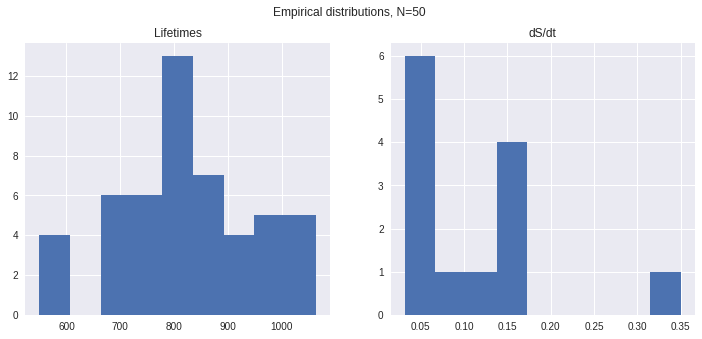

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(T, bins=9)
axes[1].hist(compute_ds(T, T), bins=9)
fig.suptitle(f'Empirical distributions, N={len(T)}')
axes[0].set_title('Lifetimes')
axes[1].set_title('dS/dt')
plt.show()

**Some assumptions are possible here:**
1. The distribution of lifetimes may be Gompertz or Weibull, but it is barely too extremal one (infitite moments or smth).
2. The distribution of differences depends on the number of observations (mice in experiment).
3. (Optional) The distribution of differences follow some kind of exponential law. 

**Conjectures:**
1. A sample from Weibull or Gompertz distribution should provide a good empirical prior for distribution of differences.
2. Samples will be drawn from model distributions fitted to the original data.
3. Extremal values of differences in the original empirical distribution serves as a non-plausible events in a "good" experiment.

**Plan**
1. Get an empirical sample;
2. Fit a model (G or W) to it;
3. Compute sample differences for empirical distribution;
4. Compute sample differences for model distribution N times;
5. Calculate p-value of given extremal difference from differences of the empirical sample.

**Important comments**
1. If researcher fill the data about mouse actual death time (for instance in the end of working week) - it introduced an additional technical noise making the data less plausible.
2. It is a problem to work with $dN$ because any model sample will contain examples with cardinality of 1 (1 time occurence).
3. Some datasets have too high binarization interval. I need to use minimum non-zero value for binning model samples.
4. I can use custom binning with respect to dataset

50


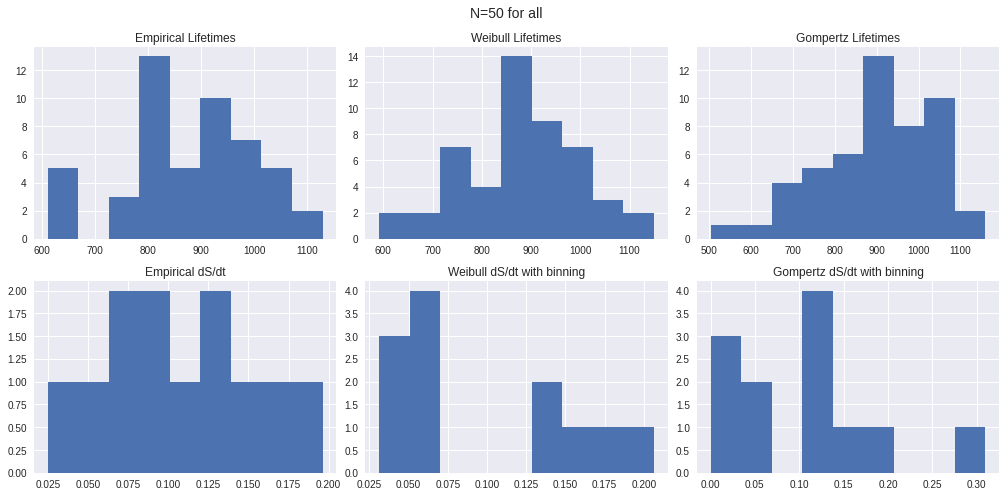

In [7]:
#take a sample
experiment = data['Curcumin experiment']#list(data.values())[0]
x = experiment['x']
y = experiment['y']
n = experiment['n']
T = convert_to_lifetimes(x, y, n) 
dS = compute_ds(T, T)
#compute differences
# dT = np.diff(T) #time differences
# _, dN = np.unique(T, return_counts=True) #mortal differences
N = len(T)
print(N)

#Fit models to the sample
wf = WeibullFitter().fit(T)
l, k = wf.lambda_, wf.rho_

ggf = GompertzFitter(T).fit(T)
A, B = ggf.nu_, ggf.b_

#draw samples from the target models
wsample = l * np.random.weibull(k, N)
gsample = generate_gompertz_sample(A, B, np.max(T), n=N)
dSw = compute_ds(wsample, T)
dSg = compute_ds(gsample, T)
#compute their differences


#plot intermediate results

fig, axes = plt.subplots(2, 3, figsize=(14, 7))
axes[0, 0].hist(T, bins=9)
axes[1, 0].hist(dS, bins=9)
axes[0, 1].hist(wsample, bins=9)
axes[1, 1].hist(dSw, bins=9)
axes[0, 2].hist(gsample, bins=9)
axes[1, 2].hist(dSg, bins=9)
fig.suptitle(f'N={len(T)} for all', fontsize=14)
axes[0, 0].set_title('Empirical Lifetimes')
axes[1, 0].set_title('Empirical dS/dt')
axes[0, 1].set_title('Weibull Lifetimes')
axes[1, 1].set_title('Weibull dS/dt with binning')
axes[0, 2].set_title('Gompertz Lifetimes')
axes[1, 2].set_title('Gompertz dS/dt with binning')
plt.tight_layout()
plt.show()

In [72]:
pl_results = pd.DataFrame()
for i, (name, experiment) in enumerate(data.items()):
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 
    n_steps = np.unique(T).shape[0]
    dS = compute_ds(T, T)
    N = len(T)

    #Fit models to the sample
    wf = WeibullFitter().fit(T)
    l, k = wf.lambda_, wf.rho_

    ggf = GompertzFitter(T).fit(T)
    A, B = ggf.nu_, ggf.b_

    #overmortality_test
    m = 1000
    tw, tg = 0, 0
    for _ in range(m):
        #draw samples from the target models
        wsample = l * np.random.weibull(k, N)
        gsample = generate_gompertz_sample(A, B, np.max(T), n=N)
        #compute their derivatives
        dSw = compute_ds(wsample, T)
        dSg = compute_ds(gsample, T)
        
        if dS.max() > dSw.max():
            tw += 1
        if dS.max() > dSg.max():
            tg += 1
    wpval = 1 - tw/m
    gpval = 1 - tg/m

    pl_results = pl_results.append({'name':name, 'w_pval':wpval, 'g_pval': gpval, 'N':N, 'n_steps':n_steps}, ignore_index=True)
    #print(f'Overmortality results for {name} (N={N}): \n Weibull target p-value = {wpval} \n Gompretz target p-value = {gpval}')
    #print()


0.567


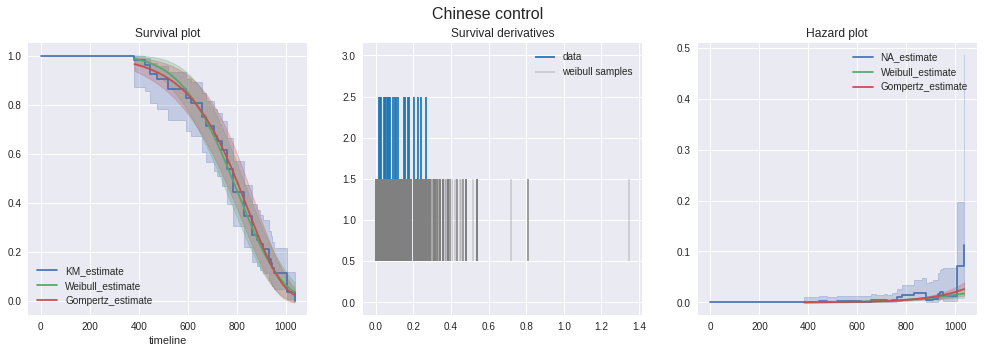

In [71]:
name = 'Chinese control'
experiment = data[name]
x = experiment['x']
y = experiment['y']
n = experiment['n']
T = convert_to_lifetimes(x, y, n) 
kf = KaplanMeierFitter().fit(T)
na = NelsonAalenFitter().fit(T)
dS = compute_ds(T, T)
N = len(T)

fig, axes = plt.subplots(1, 3, figsize=(17,5))
fig.suptitle(name, fontsize=16)
axes[0].set_title('Survival plot')
axes[1].eventplot(dS, color='tab:blue', lineoffsets=2, label='data')
axes[1].set_title('Survival derivatives')
axes[2].set_title('Hazard plot')
kf.plot_survival_function(ax=axes[0])
na.plot_hazard(ax=axes[2], bandwidth=10.0)
#axes[2].set_ylim([0, 1])

#Fit models to the sample
wf = WeibullFitter().fit(T)
l, k = wf.lambda_, wf.rho_
wf.plot_survival_function(ax=axes[0])
wf.plot_hazard(ax=axes[2])

ggf = GompertzFitter(T).fit(T)
A, B = ggf.nu_, ggf.b_
ggf.plot_survival_function(ax=axes[0])
ggf.plot_hazard(ax=axes[2])

#overmortality_test
m = 1000
tw, tg = 0, 0
for _ in range(m):
    #draw samples from the target models
    wsample = l * np.random.weibull(k, N)
    gsample = generate_gompertz_sample(A, B, np.max(T), n=N)
    #compute their derivatives
    dSw = compute_ds(wsample, T)
    dSg = compute_ds(gsample, T)

    axes[1].eventplot(dSw, color='grey', alpha=0.3)
    
    if dS.max() > dSw.max():
        tw += 1
    if dS.max() > dSg.max():
        tg += 1
axes[1].legend(['data', 'weibull samples'])
wpval = 1 - tw/m
gpval = 1- tg/m
print(wpval)

In [74]:
pl_results.sort_values('w_pval')

,name,w_pval,g_pval,N,n_steps
2,Berberine control,0.000,0.001,22,15
3,Berberine experiment,0.000,0.000,22,18
8,Keto control,0.000,0.000,58,34
5,Sirtuin experiment,0.003,0.005,50,37
12,Frailty control,0.003,0.000,25,20
0,Curcumin control,0.014,0.004,50,14
14,Circad control,0.017,0.017,42,36
9,Rapamycin2 control,0.020,0.021,39,34
11,AKG control,0.053,0.056,24,20
6,Rapamycin control,0.128,0.116,18,14


1.9028530109477049 Berberine control


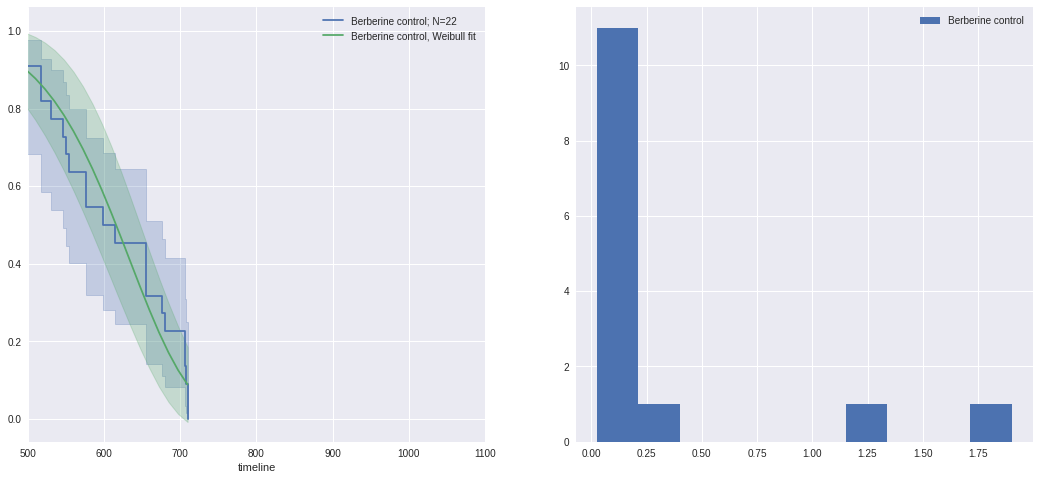

In [10]:
suspected = pl_results[pl_results.w_pval > 0.5]['name'].values
#suspected = pl_results.iloc[:2]['name'].values
suspected = [#'Curcumin control',
            #  'Sirtuin experiment',	
            #  'Sirtuin control',
            #  'Chinese control',
            #  'Curcumin experiment',
            'Berberine control'
             ]	

fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].set_xlim([500, 1100])
for name in suspected:
    experiment = data[name]
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 
    dS = compute_ds(T, T)
    print(dS.max(), name)
    kf = KaplanMeierFitter(label=f'{name}; N={len(T)}').fit(T)
    kf.plot_survival_function(ax=ax[0],)

    wf = WeibullFitter(label=f'{name}, Weibull fit').fit(T)
    wf.plot_survival_function(ax=ax[0])

    ax[1].hist(dS, label=name)
ax[1].legend()
plt.show()